# Hill Climbing

---

In this notebook, we will train hill climbing with adaptive noise scaling with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Define the Policy

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Net, self).__init__()
        fc= [128, 128]
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc[0])
        self.fc2 = nn.Linear(fc[0], fc[1])
        self.fc3 = nn.Linear(fc[1], action_size)

    def forward(self, state):        
        """Build a network that maps state -> action values."""
        #print(state)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.softmax(F.relu(self.fc3(x)))
        return x

In [3]:
env = gym.make('CartPole-v0')
print('observation space:', env.observation_space)
print('action space:', env.action_space)

class Policy():
    def __init__(self, s_size=4, a_size=2):
        self.net = Net(s_size, a_size, 42)
        
    def forward(self, state):        
        return self.net(state)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)#.to(device)
        probs = self.net.forward(state)
        #action = np.random.choice(2, p=probs) # option 1: stochastic policy
        #print(probs.data.numpy())        
        action = np.argmax(probs.data.numpy())        
        #print(probs)
        logp = torch.log(probs[0,action])
        #print(action)
        return action, logp

[2018-09-05 21:36:08,475] Making new env: CartPole-v0


observation space: Box(4,)
action space: Discrete(2)


### 3. Train the Agent with Stochastic Policy Search

In [4]:
import torch.optim as optim
from tqdm import tqdm

env = gym.make('CartPole-v0')
env.seed(0)
np.random.seed(0)

policy = Policy()

optimizer = optim.Adam(policy.net.parameters(), lr=1e-4)


def train(n_episodes=1000, max_t=1000, gamma=1.0, print_every=10):
    """Implementation of hill climbing with adaptive noise scaling.
        
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        noise_scale (float): standard deviation of additive noise
    """
    
    scores_deque = deque(maxlen=100)
    scores = []
    R_expected = 200.0    
    for i_episode in tqdm(range(1, n_episodes+1)):
        rewards = []
        state = env.reset()
        R = torch.tensor(0).float()
        saved_log_probs = []
        rewards=[]
        for t in range(max_t):
            action, logp = policy.act(state)
            state, reward, done, _ = env.step(action)  
            rewards.append(reward)
            saved_log_probs.append(logp)
            R += torch.tensor(reward).float()
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        
        #print(policy_loss)
        loss = torch.stack(policy_loss).sum()
        
        # Minimize the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))            
            break
    return scores

scores = train()

[2018-09-05 21:36:10,077] Making new env: CartPole-v0
  3%|▎         | 34/1000 [00:00<00:09, 106.67it/s]

Episode 10	Average Score: 22.00
Episode 20	Average Score: 24.55
Episode 30	Average Score: 26.70


  5%|▌         | 54/1000 [00:00<00:09, 102.76it/s]

Episode 40	Average Score: 30.85
Episode 50	Average Score: 33.82


  7%|▋         | 72/1000 [00:00<00:09, 95.49it/s] 

Episode 60	Average Score: 35.28
Episode 70	Average Score: 36.24


  9%|▉         | 90/1000 [00:00<00:10, 90.61it/s]

Episode 80	Average Score: 38.25
Episode 90	Average Score: 40.09


 11%|█         | 112/1000 [00:01<00:09, 93.19it/s]

Episode 100	Average Score: 40.50
Episode 110	Average Score: 42.45


 13%|█▎        | 133/1000 [00:01<00:09, 90.06it/s]

Episode 120	Average Score: 44.19
Episode 130	Average Score: 45.85


 15%|█▌        | 150/1000 [00:01<00:09, 86.79it/s]

Episode 140	Average Score: 46.06
Episode 150	Average Score: 45.90


 17%|█▋        | 169/1000 [00:01<00:09, 85.29it/s]

Episode 160	Average Score: 45.71
Episode 170	Average Score: 45.98


 19%|█▉        | 189/1000 [00:02<00:09, 84.32it/s]

Episode 180	Average Score: 44.85
Episode 190	Average Score: 44.13


 22%|██▏       | 219/1000 [00:02<00:09, 85.42it/s]

Episode 200	Average Score: 44.71
Episode 210	Average Score: 44.83
Episode 220	Average Score: 44.75


 24%|██▍       | 238/1000 [00:02<00:09, 84.52it/s]

Episode 230	Average Score: 45.02
Episode 240	Average Score: 45.42


 27%|██▋       | 266/1000 [00:03<00:08, 84.33it/s]

Episode 250	Average Score: 46.70
Episode 260	Average Score: 46.48


 28%|██▊       | 284/1000 [00:03<00:08, 83.70it/s]

Episode 270	Average Score: 47.22
Episode 280	Average Score: 48.59


 30%|███       | 302/1000 [00:03<00:08, 83.66it/s]

Episode 290	Average Score: 48.41
Episode 300	Average Score: 48.15


 32%|███▏      | 320/1000 [00:03<00:08, 83.74it/s]

Episode 310	Average Score: 48.05
Episode 320	Average Score: 48.34


 34%|███▍      | 340/1000 [00:04<00:07, 84.04it/s]

Episode 330	Average Score: 47.70
Episode 340	Average Score: 47.48


 36%|███▌      | 362/1000 [00:04<00:07, 84.78it/s]

Episode 350	Average Score: 46.11
Episode 360	Average Score: 46.14
Episode 370	Average Score: 44.89


 40%|███▉      | 395/1000 [00:04<00:07, 85.95it/s]

Episode 380	Average Score: 43.96
Episode 390	Average Score: 43.34
Episode 400	Average Score: 42.93


 43%|████▎     | 426/1000 [00:04<00:06, 86.23it/s]

Episode 410	Average Score: 42.44
Episode 420	Average Score: 41.92


 44%|████▍     | 445/1000 [00:05<00:06, 85.71it/s]

Episode 430	Average Score: 42.50
Episode 440	Average Score: 41.99


 46%|████▋     | 464/1000 [00:05<00:06, 85.45it/s]

Episode 450	Average Score: 42.65
Episode 460	Average Score: 43.38


 48%|████▊     | 481/1000 [00:05<00:06, 84.13it/s]

Episode 470	Average Score: 45.05
Episode 480	Average Score: 44.55


 51%|█████     | 511/1000 [00:06<00:05, 84.06it/s]

Episode 490	Average Score: 45.17
Episode 500	Average Score: 45.99
Episode 510	Average Score: 46.59


 53%|█████▎    | 532/1000 [00:06<00:05, 84.52it/s]

Episode 520	Average Score: 46.99
Episode 530	Average Score: 47.59
Episode 540	Average Score: 47.53


 57%|█████▋    | 568/1000 [00:06<00:05, 85.64it/s]

Episode 550	Average Score: 47.38
Episode 560	Average Score: 47.07
Episode 570	Average Score: 45.35


 59%|█████▉    | 589/1000 [00:06<00:04, 85.37it/s]

Episode 580	Average Score: 47.15
Episode 590	Average Score: 46.88


 61%|██████    | 610/1000 [00:07<00:04, 85.79it/s]

Episode 600	Average Score: 45.88
Episode 610	Average Score: 45.81


 63%|██████▎   | 631/1000 [00:07<00:04, 86.04it/s]

Episode 620	Average Score: 46.40
Episode 630	Average Score: 45.18
Episode 640	Average Score: 44.80


 66%|██████▋   | 663/1000 [00:07<00:03, 86.29it/s]

Episode 650	Average Score: 44.05
Episode 660	Average Score: 44.93


 68%|██████▊   | 684/1000 [00:07<00:03, 86.51it/s]

Episode 670	Average Score: 45.49
Episode 680	Average Score: 43.52


 70%|███████   | 703/1000 [00:08<00:03, 86.28it/s]

Episode 690	Average Score: 43.32
Episode 700	Average Score: 43.97


 72%|███████▏  | 721/1000 [00:08<00:03, 86.08it/s]

Episode 710	Average Score: 44.83
Episode 720	Average Score: 43.77


 74%|███████▍  | 741/1000 [00:08<00:03, 86.32it/s]

Episode 730	Average Score: 42.99
Episode 740	Average Score: 44.23


 76%|███████▌  | 761/1000 [00:08<00:02, 86.54it/s]

Episode 750	Average Score: 44.66
Episode 760	Average Score: 43.96


 78%|███████▊  | 781/1000 [00:09<00:02, 86.63it/s]

Episode 770	Average Score: 44.50
Episode 780	Average Score: 44.65


 80%|████████  | 801/1000 [00:09<00:02, 86.57it/s]

Episode 790	Average Score: 45.53
Episode 800	Average Score: 45.89


 82%|████████▏ | 820/1000 [00:09<00:02, 86.29it/s]

Episode 810	Average Score: 46.30
Episode 820	Average Score: 46.60


 84%|████████▍ | 839/1000 [00:09<00:01, 86.35it/s]

Episode 830	Average Score: 48.23
Episode 840	Average Score: 47.98


 86%|████████▋ | 865/1000 [00:10<00:01, 85.92it/s]

Episode 850	Average Score: 49.93
Episode 860	Average Score: 50.27


 88%|████████▊ | 884/1000 [00:10<00:01, 86.06it/s]

Episode 870	Average Score: 49.92
Episode 880	Average Score: 50.21


 90%|█████████ | 902/1000 [00:10<00:01, 85.66it/s]

Episode 890	Average Score: 50.00
Episode 900	Average Score: 50.04


 92%|█████████▏| 922/1000 [00:10<00:00, 85.89it/s]

Episode 910	Average Score: 49.14
Episode 920	Average Score: 49.20


 94%|█████████▍| 941/1000 [00:10<00:00, 85.82it/s]

Episode 930	Average Score: 48.59
Episode 940	Average Score: 48.04


 96%|█████████▋| 963/1000 [00:11<00:00, 86.17it/s]

Episode 950	Average Score: 46.61
Episode 960	Average Score: 47.20
Episode 970	Average Score: 46.64


100%|██████████| 1000/1000 [00:11<00:00, 86.71it/s]

Episode 980	Average Score: 46.91
Episode 990	Average Score: 46.17
Episode 1000	Average Score: 44.99


### 4. Plot the Scores

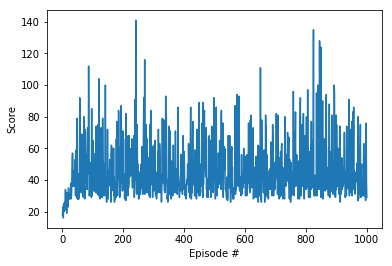

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

In [ ]:
env = gym.make('CartPole-v0')
state = env.reset()
for t in range(200):
    action = policy.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()